Image: 1231.png, Width: 512, Height: 512


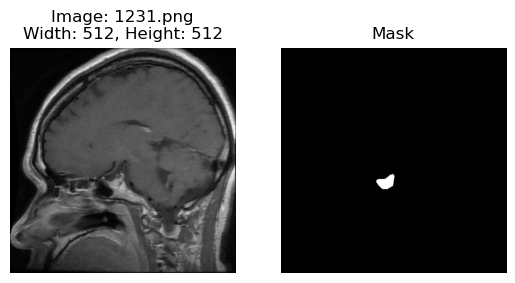

In [1]:
#Review of an image and mask in the dataset
#Import libraries
import os
import cv2
import matplotlib.pyplot as plt
import numpy

def get_image_size(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is not None:
        height, width = image.shape[:2]
        return width, height
    else:
        return None

# Replace 'image_folder_path' and 'mask_folder_path' with the actual paths to your image and mask folders on Kaggle
image_folder_path = '/kaggle/input/brain-tumor-segmentation/images'
mask_folder_path = '/kaggle/input/brain-tumor-segmentation/masks'

# List all the files in the image folder
image_files = os.listdir(image_folder_path)

if len(image_files) > 0:
    # Choose one image from the folder (you can change the index if needed)
    image_file = image_files[2]

    # Get the complete path to the image and mask
    image_path = os.path.join(image_folder_path, image_file)
    mask_file = image_file  # Assuming mask file names are the same as image file names
    mask_path = os.path.join(mask_folder_path, mask_file)

    # Get the image size
    image_size = get_image_size(image_path)

    if image_size is not None:
        print(f"Image: {image_file}, Width: {image_size[0]}, Height: {image_size[1]}")

        # Load and plot the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {image_file}\nWidth: {image_size[0]}, Height: {image_size[1]}")
        plt.axis('off')

        # Load and plot the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.show()
    else:
        print(f"Failed to read the image: {image_file}")
else:
    print("No images found in the specified folder.")

# TransUnet


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => GELU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [5]:

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        self.out=out_channels


    def forward(self, x1, x2,x3=None):
#         print(x1.shape)
#         print(x1.shape,"x1 before up")
        x1 = self.up(x1)
#         print(x1.shape,"x1 after up")
#         print(x1.shape, "after upsampling")
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
#         print(x.shape,"after cat")
        if x3 is not None:
            x=torch.cat([x,x3],dim=1)
            self.conv= DoubleConv(x.shape[1],self.out).to(x1.device) 
#         print(x2.shape,"after concat" ,x.shape, self.conv(x).shape)
            
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class PAM_Module(nn.Module):
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out

class PositionEmbeddingLearned(nn.Module):

    def __init__(self, num_pos_feats=256, len_embedding=32):
        super().__init__()
        self.row_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.col_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)

        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)

        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

        return pos

class ScaledDotProductAttention(nn.Module):
    

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature ** 0.5
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        m_batchsize, d, height, width = x.size()
        q = x.view(m_batchsize, d, -1)
        k = x.view(m_batchsize, d, -1)
        k = k.permute(0, 2, 1)
        v = x.view(m_batchsize, d, -1)

        attn = torch.matmul(q / self.temperature, k)

        if mask is not None:
            # 给需要mask的地方设置一个负无穷
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        output = output.view(m_batchsize, d, height, width)

        return output

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class MultiConv(nn.Module):
    def __init__(self, in_ch, out_ch, attn=True):
        super(MultiConv, self).__init__()

        self.fuse_attn = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.Softmax2d() if attn else nn.PReLU()
        )

    def forward(self, x):
        return self.fuse_attn(x)

In [8]:
class FPN(nn.Module) :
    def __init__(self, in_ch, out_ch) :
        self.conv_down1 = DoubleConv(3, 64)
        self.conv_down2 = DoubleConv(64, 128)
        self.conv_down3 = DoubleConv(128, 256)
        self.conv_down4 = DoubleConv(256, 512)        
        self.conv_down5 = DoubleConv(512, 1024)  
        
        

In [ ]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True,FPN=False):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.FPN=FPN
        
        if (self.FPN == True) : 
            print("this run")
            self.inc = DoubleConv(n_channels, 64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
  
            factor=2
            print(factor)
            self.down4 = Down(512, 1024 // factor)
            self.up1 = Up(1024, 512 // factor, bilinear)
            self.up2 = Up(1024, 256 // factor, bilinear)
            self.up3 = Up(512, 128 // factor, bilinear)
            self.up4 = Up(256, 64, bilinear)
            self.latlayer1 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0)
            self.latlayer2 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)
            self.latlayer3 = nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0)
            self.latlayer4 = nn.Conv2d(64, 512, kernel_size=1, stride=1, padding=0)

            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.smooth1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
            self.smooth2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
            self.smooth3 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
            self.smooth4 = nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1)


        else : 
            print("this not run")
            self.inc=DoubleConv(n_channels,64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
            factor = 2 if bilinear else 1
            self.down4 = Down(512, 1024 // factor)
#             self.toplayer = nn.Conv2d(12, 256, kernel_size=1, stride=1, padding=0)
#             self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
#             self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
#             self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
#             self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
#             self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
#             self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
            self.up1 = Up(1024, 512 // factor, bilinear)
            self.up2 = Up(1024, 256 // factor, bilinear)
            self.up3 = Up(512, 128 // factor, bilinear)
            self.up4 = Up(256, 64, bilinear)
            print("runnn")
        self.outc = OutConv(128, n_classes)
  

       
        self.pos = PositionEmbeddingLearned(512 // factor)
        print(factor)

        
        self.pam = PAM_Module(512)

        
        self.sdpa = ScaledDotProductAttention(512)

       
        self.fuse1 = MultiConv(768, 256)
        self.fuse2 = MultiConv(384, 128)
        self.fuse3 = MultiConv(192, 64)
        self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        if self.FPN == True : 
            x1 = self.inc(x) #(1,64,256,256)
#             print(x1.shape)
            x2 = self.down1(x1) #(1,128,128,128)
#             print(x2.shape)
            x3 = self.down2(x2) #(1,256,64,64)
#             print(x3.shape)
            x4 = self.down3(x3) #(1,512,32,32)
#             print(x4.shape)
            x5 = self.down4(x4) #(1,512,16,16) #down terakhir
            l4=self.latlayer1(x4) #([1, 512, 32, 32]
#             print("L4, Layer ke-empat conv 1x1", l4.shape,x4.shape)
            l3=self.latlayer2(x3)  #([1, 512, 64, 64]
#             print("L4, Layer ke-empat conv 1x1", l3.shape,x3.shape)

            l2=self.latlayer3(x2) #(1,512,128,128)
            l1=self.latlayer4(x1) # (1,512,256,256)
#             print(l4.shape,l3.shape,l2.shape)
            # Creating FPN Channel 
            p4=self.up(x5) #(1,512,32,32)
            p4_=p4+l4  #(1,512,32,32)
            p5=self.up(p4_) #(1,512,64,64)
            p5_=p5+l3 #(1,512,64,64)
            p6=self.up(p5_) #(1,512,128,128)
            p6_=p6+l2 #(1,512,128,128)
            p7=self.up(p6_) #(1,512,256,256)
            p7_=p7+l1
#             print("p6",p6.shape)
            #Smooth
            p4_=self.smooth1(p4_)
            p5_=self.smooth2(p5_)
            p6_=self.smooth3(p6_)
            p7_=self.smooth4(p7_)
            
            
            
            '''Setting 1'''
            x5_pam = self.pam(x5)

            '''Setting 2'''
            x5_pos = self.pos(x5)
            x5 = x5 + x5_pos
#             print(x5.shape)


            x5_sdpa = self.sdpa(x5)
            x5 = x5_sdpa + x5_pam #(1,512,16,16)
#             print("x5shape",x5.shape)
#             print(x5.shape)


            x6 = self.up1(x5, p4_) ## Langsung Cat Aja ,#(1,256,32,32)
#             print("x6",x6.shape)
            x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
#             print(f"{x5_scale.shape}, ini abis scaling")
            x6_cat = torch.cat((x5_scale, x6), 1) #(b,512,32,32)
#             print("x6_cat",x6_cat.shape)

            x7 = self.up2(x6_cat,p5_) #(1,128,64,64)
            x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True) #(1,256,32,32)
            x7_cat = torch.cat((x6_scale, x7), 1) #(b,128,64,64)
            x8 = self.up3(x7_cat, p6_)  #(b,64,128,128)
            x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True) #(1,128,64,64)
            x8_cat = torch.cat((x7_scale, x8), 1) 
                
            x9 = self.up4(x8_cat, p7_)
            x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
            x9 = torch.cat((x8_scale, x9), 1)


            logits = self.outc(x9)
        else : 
            print("this is running")
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)


            '''Setting 1'''
            x5_pam = self.pam(x5)

            '''Setting 2'''
            x5_pos = self.pos(x5)
            x5 = x5 + x5_pos


            x5_sdpa = self.sdpa(x5)
            x5 = x5_sdpa + x5_pam


            x6 = self.up1(x5, x4)
            x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
            x6_cat = torch.cat((x5_scale, x6), 1)


            x7 = self.up2(x6_cat, x3)
            x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
            x7_cat = torch.cat((x6_scale, x7), 1)

            x8 = self.up3(x7_cat, x2)
            x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
            x8_cat = torch.cat((x7_scale, x8), 1)

            x9 = self.up4(x8_cat, x1)
            x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
            x9 = torch.cat((x8_scale, x9), 1)

            logits = self.outc(x9)       
        return logits
#     def upsample(self, x, h, w):
#             sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
#             return sample(x)
#     def upsample_add(self, x, y):
#         _,_,H,W = y.size()
#         upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        
#         return upsample(x) + y

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [11]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

        if self.transform:
            # Apply any desired transformations (e.g., resizing, normalization, data augmentation)
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [12]:
# Function to create train and test data loaders
def create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=4):
    # Dataset transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images and masks to 256x256
        transforms.ToTensor(),
    ])

    # Create datasets
    train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform)
    val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transform)  # Validation dataset
    test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)  # No need to shuffle the validation set
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [13]:
from tqdm import tqdm

def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, early_stopping=None):
    train_loss_values = []
    val_loss_values = []
    train_ious=[]
    val_ious=[]

    best_model_state = None
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        dcie = 0.0
        train_iou=0.0

        # Training loop
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()

            # Move images and masks to device (GPU if available)
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = dice_loss2(masks, torch.sigmoid(outputs))
            
            dcies = dice_loss2(masks, torch.sigmoid(outputs))
            

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_iou+=calculate_iou(masks, torch.sigmoid(outputs))
            dcie += dcies.item()

        # Calculate and store the average training loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_values.append(epoch_train_loss)
        train_ious.append(train_iou)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}")
        print(f"Epoch {epoch+1}/{num_epochs}, Dice Loss: {dcie/len(train_loader)}")
        print(f"Epoch {epoch+1}/{num_epochs}, IOU: {train_iou/len(train_loader)}")
        print(f"Epoch {epoch+1}/{num_epochs}, Dice Coef: {1-(dcie/len(train_loader))}")

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_dcie = 0.0
        val_iou=0.0
        with torch.no_grad():
            for val_images, val_masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
#                 val_loss = criterion(val_outputs, val_masks)
                val_loss=dice_loss2(val_masks,torch.sigmoid(val_outputs))
                dcies_val = dice_loss2(val_masks, torch.sigmoid(val_outputs))

                val_running_loss += val_loss.item()
                val_dcie += dcies_val.item()
                val_iou+=calculate_iou(val_masks,torch.sigmoid(val_outputs))

        # Calculate and store the average validation loss for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        val_loss_values.append(epoch_val_loss)
        val_ious.append(val_iou)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}")
        print(f"Epoch {epoch+1}/{num_epochs}, Dice Loss: {val_dcie/len(val_loader)}")
        print(f"Epoch {epoch+1}/{num_epochs}, Val_IOU: {val_iou/len(val_loader)}")
        print(f"Epoch {epoch+1}/{num_epochs}, Dice Coef: {1-(val_dcie/len(val_loader))}")

        if early_stopping is not None:
            early_stopping(epoch_val_loss)
            if early_stopping.stop_training:
                print("Early stopping the training process.")
                break

        # Update best model state if necessary
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_state = model.state_dict()

    return train_loss_values, val_loss_values,train_ious,val_ious, best_model_state

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min'):
        self.patience = patience
        self.mode = mode
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

        if mode == 'min':
            self.best_loss = float('inf')
        elif mode == 'max':
            self.best_loss = float('-inf')
        else:
            raise ValueError("Invalid mode. Use 'min' or 'max'.")

    def __call__(self, current_loss):
        if self.mode == 'min' and current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        elif self.mode == 'max' and current_loss > self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.stop_training = True
            print("Early stopping the training process.")

In [15]:
# Function to save the best model's state to a file
def save_best_model(model_state, filename):
    torch.save(model_state, filename)

In [16]:
import torch
import torch.nn.functional as F

# Function to calculate Intersection over Union (IoU)
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = (true_mask > threshold).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

# Train and test

In [17]:
# Example usage:
if __name__ == "__main__":
    image_folder = '/kaggle/input/brain-tumor-segmentation/images'
    mask_folder = '/kaggle/input/brain-tumor-segmentation/masks'
    
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    mask_paths = [os.path.join(mask_folder, mask) for mask in os.listdir(mask_folder)]

    num_samples = len(image_paths)
    train_size = int(0.8 * num_samples)  # 80% for training and validation, 20% for testing
    val_size = (num_samples - train_size) // 2
    indices = np.random.permutation(num_samples)
    train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

    train_image_paths = [image_paths[i] for i in train_indices]
    train_mask_paths = [mask_paths[i] for i in train_indices]
    val_image_paths = [image_paths[i] for i in val_indices]
    val_mask_paths = [mask_paths[i] for i in val_indices]
    test_image_paths = [image_paths[i] for i in test_indices]
    test_mask_paths = [mask_paths[i] for i in test_indices]

    # Initialize the UNet model
    in_channels = 3
    out_channels = 1
    model = UNet_Attention_Transformer_Multiscale(in_channels, out_channels,True,True)

    # Move the model to the device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for binary segmentation
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=8)

this run
2
2


In [18]:
def dice_loss2(y_true, y_pred):
    # Ensure y_pred is on the same device as y_true
    y_pred = y_pred.to(y_true.device)
    return 1.0 - (dice_coef(y_true, y_pred))

def dice_coef(y_true, y_pred):
    # Ensure y_pred is on the same device as y_true
    y_pred = y_pred.to(y_true.device)
    
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = torch.sum(y_true_flat * y_pred_flat)
    y_true_sum = torch.sum(y_true_flat)
    y_pred_sum = torch.sum(y_pred_flat)
    
    return (2.0 * intersection + 1) / (y_true_sum + y_pred_sum + 1)

# Assuming mask and prediction are already on the same device


Epoch 1/100: 100%|██████████| 307/307 [04:05<00:00,  1.25it/s]


Epoch 1/100, Train Loss: 0.8613080675516532
Epoch 1/100, Dice Loss: 0.8613080675516532
Epoch 1/100, IOU: 0.13188534781203304
Epoch 1/100, Dice Coef: 0.13869193244834677


Epoch 1/100 (Validation): 100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Epoch 1/100, Validation Loss: 0.8317726101630774
Epoch 1/100, Dice Loss: 0.8317726101630774
Epoch 1/100, Val_IOU: 0.15159754913586837
Epoch 1/100, Dice Coef: 0.16822738983692265


Epoch 2/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 2/100, Train Loss: 0.7196012700419473
Epoch 2/100, Dice Loss: 0.7196012700419473
Epoch 2/100, IOU: 0.30108344701728523
Epoch 2/100, Dice Coef: 0.2803987299580527


Epoch 2/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 2/100, Validation Loss: 0.7471108299035293
Epoch 2/100, Dice Loss: 0.7471108299035293
Epoch 2/100, Val_IOU: 0.23921550370943853
Epoch 2/100, Dice Coef: 0.2528891700964707


Epoch 3/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 3/100, Train Loss: 0.5979519152485975
Epoch 3/100, Dice Loss: 0.5979519152485975
Epoch 3/100, IOU: 0.4092363986499146
Epoch 3/100, Dice Coef: 0.4020480847514025


Epoch 3/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 3/100, Validation Loss: 0.5586356321970621
Epoch 3/100, Dice Loss: 0.5586356321970621
Epoch 3/100, Val_IOU: 0.42587435780427396
Epoch 3/100, Dice Coef: 0.44136436780293786


Epoch 4/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 4/100, Train Loss: 0.48905261972439795
Epoch 4/100, Dice Loss: 0.48905261972439795
Epoch 4/100, IOU: 0.5005617049986842
Epoch 4/100, Dice Coef: 0.510947380275602


Epoch 4/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 4/100, Validation Loss: 0.5503724400813763
Epoch 4/100, Dice Loss: 0.5503724400813763
Epoch 4/100, Val_IOU: 0.38385040217485183
Epoch 4/100, Dice Coef: 0.4496275599186237


Epoch 5/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 5/100, Train Loss: 0.41463595939381503
Epoch 5/100, Dice Loss: 0.41463595939381503
Epoch 5/100, IOU: 0.553613218014714
Epoch 5/100, Dice Coef: 0.585364040606185


Epoch 5/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 5/100, Validation Loss: 0.506909232873183
Epoch 5/100, Dice Loss: 0.506909232873183
Epoch 5/100, Val_IOU: 0.4775428015452165
Epoch 5/100, Dice Coef: 0.493090767126817


Epoch 6/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 6/100, Train Loss: 0.3631198497470893
Epoch 6/100, Dice Loss: 0.3631198497470893
Epoch 6/100, IOU: 0.5844595858444996
Epoch 6/100, Dice Coef: 0.6368801502529107


Epoch 6/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 6/100, Validation Loss: 0.37655003865559894
Epoch 6/100, Dice Loss: 0.37655003865559894
Epoch 6/100, Val_IOU: 0.5499763099046854
Epoch 6/100, Dice Coef: 0.6234499613444011


Epoch 7/100: 100%|██████████| 307/307 [03:31<00:00,  1.45it/s]


Epoch 7/100, Train Loss: 0.3188315888181183
Epoch 7/100, Dice Loss: 0.3188315888181183
Epoch 7/100, IOU: 0.6206552166406806
Epoch 7/100, Dice Coef: 0.6811684111818817


Epoch 7/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


Epoch 7/100, Validation Loss: 0.4108206507487175
Epoch 7/100, Dice Loss: 0.4108206507487175
Epoch 7/100, Val_IOU: 0.4835667854700333
Epoch 7/100, Dice Coef: 0.5891793492512825


Epoch 8/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 8/100, Train Loss: 0.28647836237077995
Epoch 8/100, Dice Loss: 0.28647836237077995
Epoch 8/100, IOU: 0.6473590152077255
Epoch 8/100, Dice Coef: 0.71352163762922


Epoch 8/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]


Epoch 8/100, Validation Loss: 0.3151543446076222
Epoch 8/100, Dice Loss: 0.3151543446076222
Epoch 8/100, Val_IOU: 0.5982447954324576
Epoch 8/100, Dice Coef: 0.6848456553923779


Epoch 9/100: 100%|██████████| 307/307 [03:31<00:00,  1.45it/s]


Epoch 9/100, Train Loss: 0.26343181564287566
Epoch 9/100, Dice Loss: 0.26343181564287566
Epoch 9/100, IOU: 0.6633083267980756
Epoch 9/100, Dice Coef: 0.7365681843571243


Epoch 9/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 9/100, Validation Loss: 0.29942359832616955
Epoch 9/100, Dice Loss: 0.29942359832616955
Epoch 9/100, Val_IOU: 0.6233971011944306
Epoch 9/100, Dice Coef: 0.7005764016738305


Epoch 10/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 10/100, Train Loss: 0.24507146433044333
Epoch 10/100, Dice Loss: 0.24507146433044333
Epoch 10/100, IOU: 0.678079524820713
Epoch 10/100, Dice Coef: 0.7549285356695566


Epoch 10/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 10/100, Validation Loss: 0.2749410439760257
Epoch 10/100, Dice Loss: 0.2749410439760257
Epoch 10/100, Val_IOU: 0.6421334223869519
Epoch 10/100, Dice Coef: 0.7250589560239743


Epoch 11/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 11/100, Train Loss: 0.2299060176948771
Epoch 11/100, Dice Loss: 0.2299060176948771
Epoch 11/100, IOU: 0.6935589909553528
Epoch 11/100, Dice Coef: 0.7700939823051229


Epoch 11/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 11/100, Validation Loss: 0.2635734050701826
Epoch 11/100, Dice Loss: 0.2635734050701826
Epoch 11/100, Val_IOU: 0.645707504107402
Epoch 11/100, Dice Coef: 0.7364265949298174


Epoch 12/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 12/100, Train Loss: 0.2129105180016558
Epoch 12/100, Dice Loss: 0.2129105180016558
Epoch 12/100, IOU: 0.7092940688909848
Epoch 12/100, Dice Coef: 0.7870894819983442


Epoch 12/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 12/100, Validation Loss: 0.29191679068100757
Epoch 12/100, Dice Loss: 0.29191679068100757
Epoch 12/100, Val_IOU: 0.6128981839387845
Epoch 12/100, Dice Coef: 0.7080832093189924


Epoch 13/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 13/100, Train Loss: 0.20184150639108417
Epoch 13/100, Dice Loss: 0.20184150639108417
Epoch 13/100, IOU: 0.7193842948647975
Epoch 13/100, Dice Coef: 0.7981584936089159


Epoch 13/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 13/100, Validation Loss: 0.27702607405491364
Epoch 13/100, Dice Loss: 0.27702607405491364
Epoch 13/100, Val_IOU: 0.6304433995332474
Epoch 13/100, Dice Coef: 0.7229739259450864


Epoch 14/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 14/100, Train Loss: 0.19002541482254426
Epoch 14/100, Dice Loss: 0.19002541482254426
Epoch 14/100, IOU: 0.7328620699601376
Epoch 14/100, Dice Coef: 0.8099745851774558


Epoch 14/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 14/100, Validation Loss: 0.25060657507334
Epoch 14/100, Dice Loss: 0.25060657507334
Epoch 14/100, Val_IOU: 0.6538807742106609
Epoch 14/100, Dice Coef: 0.7493934249266601


Epoch 15/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 15/100, Train Loss: 0.1868738339855927
Epoch 15/100, Dice Loss: 0.1868738339855927
Epoch 15/100, IOU: 0.7338641182995774
Epoch 15/100, Dice Coef: 0.8131261660144073


Epoch 15/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 15/100, Validation Loss: 0.2666161411847824
Epoch 15/100, Dice Loss: 0.2666161411847824
Epoch 15/100, Val_IOU: 0.631650706132253
Epoch 15/100, Dice Coef: 0.7333838588152176


Epoch 16/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 16/100, Train Loss: 0.18227389173321304
Epoch 16/100, Dice Loss: 0.18227389173321304
Epoch 16/100, IOU: 0.7381526102654709
Epoch 16/100, Dice Coef: 0.8177261082667869


Epoch 16/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 16/100, Validation Loss: 0.23044937390547532
Epoch 16/100, Dice Loss: 0.23044937390547532
Epoch 16/100, Val_IOU: 0.6731496850649515
Epoch 16/100, Dice Coef: 0.7695506260945246


Epoch 17/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 17/100, Train Loss: 0.16567934433101442
Epoch 17/100, Dice Loss: 0.16567934433101442
Epoch 17/100, IOU: 0.7585214228894113
Epoch 17/100, Dice Coef: 0.8343206556689856


Epoch 17/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


Epoch 17/100, Validation Loss: 0.22793433605096278
Epoch 17/100, Dice Loss: 0.22793433605096278
Epoch 17/100, Val_IOU: 0.6733309221573365
Epoch 17/100, Dice Coef: 0.7720656639490372


Epoch 18/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 18/100, Train Loss: 0.16102620134136186
Epoch 18/100, Dice Loss: 0.16102620134136186
Epoch 18/100, IOU: 0.7633737803282101
Epoch 18/100, Dice Coef: 0.8389737986586381


Epoch 18/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 18/100, Validation Loss: 0.25981831092100877
Epoch 18/100, Dice Loss: 0.25981831092100877
Epoch 18/100, Val_IOU: 0.6236716592923189
Epoch 18/100, Dice Coef: 0.7401816890789912


Epoch 19/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 19/100, Train Loss: 0.15490666216281804
Epoch 19/100, Dice Loss: 0.15490666216281804
Epoch 19/100, IOU: 0.7698324566361182
Epoch 19/100, Dice Coef: 0.845093337837182


Epoch 19/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 19/100, Validation Loss: 0.22231691005902413
Epoch 19/100, Dice Loss: 0.22231691005902413
Epoch 19/100, Val_IOU: 0.6738230807658954
Epoch 19/100, Dice Coef: 0.7776830899409759


Epoch 20/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 20/100, Train Loss: 0.14737373512808585
Epoch 20/100, Dice Loss: 0.14737373512808585
Epoch 20/100, IOU: 0.7795619889851113
Epoch 20/100, Dice Coef: 0.8526262648719142


Epoch 20/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 20/100, Validation Loss: 0.20491937490609977
Epoch 20/100, Dice Loss: 0.20491937490609977
Epoch 20/100, Val_IOU: 0.6974924481832064
Epoch 20/100, Dice Coef: 0.7950806250939002


Epoch 21/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 21/100, Train Loss: 0.14070772814051724
Epoch 21/100, Dice Loss: 0.14070772814051724
Epoch 21/100, IOU: 0.7885713486989857
Epoch 21/100, Dice Coef: 0.8592922718594828


Epoch 21/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 21/100, Validation Loss: 0.2097029120494158
Epoch 21/100, Dice Loss: 0.2097029120494158
Epoch 21/100, Val_IOU: 0.689076202802169
Epoch 21/100, Dice Coef: 0.7902970879505842


Epoch 22/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 22/100, Train Loss: 0.13269327750811746
Epoch 22/100, Dice Loss: 0.13269327750811746
Epoch 22/100, IOU: 0.7986783163943586
Epoch 22/100, Dice Coef: 0.8673067224918826


Epoch 22/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 22/100, Validation Loss: 0.1989338000615438
Epoch 22/100, Dice Loss: 0.1989338000615438
Epoch 22/100, Val_IOU: 0.7021272174822979
Epoch 22/100, Dice Coef: 0.8010661999384562


Epoch 23/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 23/100, Train Loss: 0.13083024308425206
Epoch 23/100, Dice Loss: 0.13083024308425206
Epoch 23/100, IOU: 0.8004879268062232
Epoch 23/100, Dice Coef: 0.8691697569157479


Epoch 23/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 23/100, Validation Loss: 0.22327059507369995
Epoch 23/100, Dice Loss: 0.22327059507369995
Epoch 23/100, Val_IOU: 0.6695356575342325
Epoch 23/100, Dice Coef: 0.7767294049263


Epoch 24/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 24/100, Train Loss: 0.12924856277552801
Epoch 24/100, Dice Loss: 0.12924856277552801
Epoch 24/100, IOU: 0.8024675725725652
Epoch 24/100, Dice Coef: 0.870751437224472


Epoch 24/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 24/100, Validation Loss: 0.21511676678290734
Epoch 24/100, Dice Loss: 0.21511676678290734
Epoch 24/100, Val_IOU: 0.6804514152881427
Epoch 24/100, Dice Coef: 0.7848832332170926


Epoch 25/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 25/100, Train Loss: 0.1281441114236167
Epoch 25/100, Dice Loss: 0.1281441114236167
Epoch 25/100, IOU: 0.8025313850722794
Epoch 25/100, Dice Coef: 0.8718558885763833


Epoch 25/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 25/100, Validation Loss: 0.24004973203707963
Epoch 25/100, Dice Loss: 0.24004973203707963
Epoch 25/100, Val_IOU: 0.6436925866664984
Epoch 25/100, Dice Coef: 0.7599502679629204


Epoch 26/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 26/100, Train Loss: 0.1232172153671712
Epoch 26/100, Dice Loss: 0.1232172153671712
Epoch 26/100, IOU: 0.8091668350688798
Epoch 26/100, Dice Coef: 0.8767827846328288


Epoch 26/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 26/100, Validation Loss: 0.21359236270953447
Epoch 26/100, Dice Loss: 0.21359236270953447
Epoch 26/100, Val_IOU: 0.6790902515252432
Epoch 26/100, Dice Coef: 0.7864076372904656


Epoch 27/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 27/100, Train Loss: 0.1162782191065313
Epoch 27/100, Dice Loss: 0.1162782191065313
Epoch 27/100, IOU: 0.8197791733648567
Epoch 27/100, Dice Coef: 0.8837217808934688


Epoch 27/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 27/100, Validation Loss: 0.1933646737000881
Epoch 27/100, Dice Loss: 0.1933646737000881
Epoch 27/100, Val_IOU: 0.7041495144367218
Epoch 27/100, Dice Coef: 0.8066353262999119


Epoch 28/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 28/100, Train Loss: 0.11184626351738597
Epoch 28/100, Dice Loss: 0.11184626351738597
Epoch 28/100, IOU: 0.8261737922503816
Epoch 28/100, Dice Coef: 0.888153736482614


Epoch 28/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


Epoch 28/100, Validation Loss: 0.19198687718464777
Epoch 28/100, Dice Loss: 0.19198687718464777
Epoch 28/100, Val_IOU: 0.705890553119855
Epoch 28/100, Dice Coef: 0.8080131228153522


Epoch 29/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 29/100, Train Loss: 0.10900247194091349
Epoch 29/100, Dice Loss: 0.10900247194091349
Epoch 29/100, IOU: 0.8303918405542157
Epoch 29/100, Dice Coef: 0.8909975280590865


Epoch 29/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 29/100, Validation Loss: 0.21108978528242844
Epoch 29/100, Dice Loss: 0.21108978528242844
Epoch 29/100, Val_IOU: 0.678181623801207
Epoch 29/100, Dice Coef: 0.7889102147175715


Epoch 30/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 30/100, Train Loss: 0.10779465487414928
Epoch 30/100, Dice Loss: 0.10779465487414928
Epoch 30/100, IOU: 0.8320739575045893
Epoch 30/100, Dice Coef: 0.8922053451258507


Epoch 30/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 30/100, Validation Loss: 0.18600095846714118
Epoch 30/100, Dice Loss: 0.18600095846714118
Epoch 30/100, Val_IOU: 0.7123869405342982
Epoch 30/100, Dice Coef: 0.8139990415328588


Epoch 31/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 31/100, Train Loss: 0.10338987609074247
Epoch 31/100, Dice Loss: 0.10338987609074247
Epoch 31/100, IOU: 0.8381596949279114
Epoch 31/100, Dice Coef: 0.8966101239092575


Epoch 31/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 31/100, Validation Loss: 0.18245439346020037
Epoch 31/100, Dice Loss: 0.18245439346020037
Epoch 31/100, Val_IOU: 0.7178310981163611
Epoch 31/100, Dice Coef: 0.8175456065397997


Epoch 32/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 32/100, Train Loss: 0.1032765247534463
Epoch 32/100, Dice Loss: 0.1032765247534463
Epoch 32/100, IOU: 0.8371925251103379
Epoch 32/100, Dice Coef: 0.8967234752465537


Epoch 32/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 32/100, Validation Loss: 0.18258206966595772
Epoch 32/100, Dice Loss: 0.18258206966595772
Epoch 32/100, Val_IOU: 0.7174549400806427
Epoch 32/100, Dice Coef: 0.8174179303340423


Epoch 33/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 33/100, Train Loss: 0.10341083459823061
Epoch 33/100, Dice Loss: 0.10341083459823061
Epoch 33/100, IOU: 0.8371473890562399
Epoch 33/100, Dice Coef: 0.8965891654017694


Epoch 33/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 33/100, Validation Loss: 0.18293836330756164
Epoch 33/100, Dice Loss: 0.18293836330756164
Epoch 33/100, Val_IOU: 0.7155147126087775
Epoch 33/100, Dice Coef: 0.8170616366924384


Epoch 34/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 34/100, Train Loss: 0.09546433442578642
Epoch 34/100, Dice Loss: 0.09546433442578642
Epoch 34/100, IOU: 0.8492477732294934
Epoch 34/100, Dice Coef: 0.9045356655742136


Epoch 34/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


Epoch 34/100, Validation Loss: 0.18063013370220476
Epoch 34/100, Dice Loss: 0.18063013370220476
Epoch 34/100, Val_IOU: 0.7188184154339325
Epoch 34/100, Dice Coef: 0.8193698662977953


Epoch 35/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 35/100, Train Loss: 0.09197791158570529
Epoch 35/100, Dice Loss: 0.09197791158570529
Epoch 35/100, IOU: 0.8547354121161594
Epoch 35/100, Dice Coef: 0.9080220884142947


Epoch 35/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 35/100, Validation Loss: 0.2304466534883548
Epoch 35/100, Dice Loss: 0.2304466534883548
Epoch 35/100, Val_IOU: 0.6505140463511149
Epoch 35/100, Dice Coef: 0.7695533465116452


Epoch 36/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 36/100, Train Loss: 0.09272715653192726
Epoch 36/100, Dice Loss: 0.09272715653192726
Epoch 36/100, IOU: 0.8526149283402906
Epoch 36/100, Dice Coef: 0.9072728434680728


Epoch 36/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 36/100, Validation Loss: 0.1819420304053869
Epoch 36/100, Dice Loss: 0.1819420304053869
Epoch 36/100, Val_IOU: 0.7153699497381846
Epoch 36/100, Dice Coef: 0.8180579695946131


Epoch 37/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 37/100, Train Loss: 0.09201462377554431
Epoch 37/100, Dice Loss: 0.09201462377554431
Epoch 37/100, IOU: 0.8540985988095063
Epoch 37/100, Dice Coef: 0.9079853762244556


Epoch 37/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 37/100, Validation Loss: 0.1859626311522264
Epoch 37/100, Dice Loss: 0.1859626311522264
Epoch 37/100, Val_IOU: 0.7099013802332755
Epoch 37/100, Dice Coef: 0.8140373688477736


Epoch 38/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 38/100, Train Loss: 0.0920203409676443
Epoch 38/100, Dice Loss: 0.0920203409676443
Epoch 38/100, IOU: 0.8533760398529252
Epoch 38/100, Dice Coef: 0.9079796590323557


Epoch 38/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 38/100, Validation Loss: 0.18802915933804634
Epoch 38/100, Dice Loss: 0.18802915933804634
Epoch 38/100, Val_IOU: 0.708740370395856
Epoch 38/100, Dice Coef: 0.8119708406619537


Epoch 39/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 39/100, Train Loss: 0.08592406682160468
Epoch 39/100, Dice Loss: 0.08592406682160468
Epoch 39/100, IOU: 0.8632990933396529
Epoch 39/100, Dice Coef: 0.9140759331783953


Epoch 39/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 39/100, Validation Loss: 0.181671020312187
Epoch 39/100, Dice Loss: 0.181671020312187
Epoch 39/100, Val_IOU: 0.7164395375129504
Epoch 39/100, Dice Coef: 0.818328979687813


Epoch 40/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 40/100, Train Loss: 0.08424291762156284
Epoch 40/100, Dice Loss: 0.08424291762156284
Epoch 40/100, IOU: 0.8653517806180525
Epoch 40/100, Dice Coef: 0.9157570823784371


Epoch 40/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 40/100, Validation Loss: 0.17796112329531938
Epoch 40/100, Dice Loss: 0.17796112329531938
Epoch 40/100, Val_IOU: 0.7201243898807428
Epoch 40/100, Dice Coef: 0.8220388767046807


Epoch 41/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 41/100, Train Loss: 0.08374056540405324
Epoch 41/100, Dice Loss: 0.08374056540405324
Epoch 41/100, IOU: 0.8664542632693188
Epoch 41/100, Dice Coef: 0.9162594345959467


Epoch 41/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 41/100, Validation Loss: 0.17906989042575544
Epoch 41/100, Dice Loss: 0.17906989042575544
Epoch 41/100, Val_IOU: 0.7180506418912839
Epoch 41/100, Dice Coef: 0.8209301095742445


Epoch 42/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 42/100, Train Loss: 0.08017520407512056
Epoch 42/100, Dice Loss: 0.08017520407512056
Epoch 42/100, IOU: 0.8722036787663686
Epoch 42/100, Dice Coef: 0.9198247959248794


Epoch 42/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 42/100, Validation Loss: 0.1968867839911045
Epoch 42/100, Dice Loss: 0.1968867839911045
Epoch 42/100, Val_IOU: 0.6940173491453513
Epoch 42/100, Dice Coef: 0.8031132160088955


Epoch 43/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 43/100, Train Loss: 0.08044437476788747
Epoch 43/100, Dice Loss: 0.08044437476788747
Epoch 43/100, IOU: 0.8717900099117515
Epoch 43/100, Dice Coef: 0.9195556252321125


Epoch 43/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 43/100, Validation Loss: 0.18567437544847146
Epoch 43/100, Dice Loss: 0.18567437544847146
Epoch 43/100, Val_IOU: 0.7086438322678591
Epoch 43/100, Dice Coef: 0.8143256245515286


Epoch 44/100: 100%|██████████| 307/307 [03:31<00:00,  1.45it/s]


Epoch 44/100, Train Loss: 0.07681576339740319
Epoch 44/100, Dice Loss: 0.07681576339740319
Epoch 44/100, IOU: 0.8775304365624046
Epoch 44/100, Dice Coef: 0.9231842366025969


Epoch 44/100 (Validation): 100%|██████████| 39/39 [00:13<00:00,  2.95it/s]


Epoch 44/100, Validation Loss: 0.18150702806619498
Epoch 44/100, Dice Loss: 0.18150702806619498
Epoch 44/100, Val_IOU: 0.7151374427171854
Epoch 44/100, Dice Coef: 0.818492971933805


Epoch 45/100: 100%|██████████| 307/307 [03:32<00:00,  1.45it/s]


Epoch 45/100, Train Loss: 0.07768239027514132
Epoch 45/100, Dice Loss: 0.07768239027514132
Epoch 45/100, IOU: 0.8766815040127074
Epoch 45/100, Dice Coef: 0.9223176097248587


Epoch 45/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 45/100, Validation Loss: 0.1785685007388775
Epoch 45/100, Dice Loss: 0.1785685007388775
Epoch 45/100, Val_IOU: 0.71771822984402
Epoch 45/100, Dice Coef: 0.8214314992611225


Epoch 46/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 46/100, Train Loss: 0.07563045087000446
Epoch 46/100, Dice Loss: 0.07563045087000446
Epoch 46/100, IOU: 0.879397142011102
Epoch 46/100, Dice Coef: 0.9243695491299956


Epoch 46/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 46/100, Validation Loss: 0.17733351389567056
Epoch 46/100, Dice Loss: 0.17733351389567056
Epoch 46/100, Val_IOU: 0.7197299500306448
Epoch 46/100, Dice Coef: 0.8226664861043295


Epoch 47/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 47/100, Train Loss: 0.0743864013628385
Epoch 47/100, Dice Loss: 0.0743864013628385
Epoch 47/100, IOU: 0.8809444927625625
Epoch 47/100, Dice Coef: 0.9256135986371615


Epoch 47/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


Epoch 47/100, Validation Loss: 0.18449388253383148
Epoch 47/100, Dice Loss: 0.18449388253383148
Epoch 47/100, Val_IOU: 0.7093382745217054
Epoch 47/100, Dice Coef: 0.8155061174661685


Epoch 48/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 48/100, Train Loss: 0.07433786027206271
Epoch 48/100, Dice Loss: 0.07433786027206271
Epoch 48/100, IOU: 0.8811393390843457
Epoch 48/100, Dice Coef: 0.9256621397279373


Epoch 48/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 48/100, Validation Loss: 0.18248017170490363
Epoch 48/100, Dice Loss: 0.18248017170490363
Epoch 48/100, Val_IOU: 0.7102791330753229
Epoch 48/100, Dice Coef: 0.8175198282950964


Epoch 49/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 49/100, Train Loss: 0.07367642131612821
Epoch 49/100, Dice Loss: 0.07367642131612821
Epoch 49/100, IOU: 0.8816779708241018
Epoch 49/100, Dice Coef: 0.9263235786838718


Epoch 49/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 49/100, Validation Loss: 0.17646428102102035
Epoch 49/100, Dice Loss: 0.17646428102102035
Epoch 49/100, Val_IOU: 0.7196933978643173
Epoch 49/100, Dice Coef: 0.8235357189789796


Epoch 50/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 50/100, Train Loss: 0.07023959517090639
Epoch 50/100, Dice Loss: 0.07023959517090639
Epoch 50/100, IOU: 0.8876198454477888
Epoch 50/100, Dice Coef: 0.9297604048290936


Epoch 50/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 50/100, Validation Loss: 0.17559352899209046
Epoch 50/100, Dice Loss: 0.17559352899209046
Epoch 50/100, Val_IOU: 0.7206049683766488
Epoch 50/100, Dice Coef: 0.8244064710079095


Epoch 51/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 51/100, Train Loss: 0.06850753312002175
Epoch 51/100, Dice Loss: 0.06850753312002175
Epoch 51/100, IOU: 0.8907190475867703
Epoch 51/100, Dice Coef: 0.9314924668799782


Epoch 51/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.28it/s]


Epoch 51/100, Validation Loss: 0.18357080221176147
Epoch 51/100, Dice Loss: 0.18357080221176147
Epoch 51/100, Val_IOU: 0.7081841215109214
Epoch 51/100, Dice Coef: 0.8164291977882385


Epoch 52/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 52/100, Train Loss: 0.06709545753677816
Epoch 52/100, Dice Loss: 0.06709545753677816
Epoch 52/100, IOU: 0.8933033962591463
Epoch 52/100, Dice Coef: 0.9329045424632219


Epoch 52/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 52/100, Validation Loss: 0.1780582620547368
Epoch 52/100, Dice Loss: 0.1780582620547368
Epoch 52/100, Val_IOU: 0.7163252692956191
Epoch 52/100, Dice Coef: 0.8219417379452632


Epoch 53/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 53/100, Train Loss: 0.06651111456780946
Epoch 53/100, Dice Loss: 0.06651111456780946
Epoch 53/100, IOU: 0.8942568853546043
Epoch 53/100, Dice Coef: 0.9334888854321906


Epoch 53/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 53/100, Validation Loss: 0.17591340419573662
Epoch 53/100, Dice Loss: 0.17591340419573662
Epoch 53/100, Val_IOU: 0.7200064980066739
Epoch 53/100, Dice Coef: 0.8240865958042634


Epoch 54/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 54/100, Train Loss: 0.06618314903799796
Epoch 54/100, Dice Loss: 0.06618314903799796
Epoch 54/100, IOU: 0.8945939041892558
Epoch 54/100, Dice Coef: 0.9338168509620021


Epoch 54/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 54/100, Validation Loss: 0.18064193083689764
Epoch 54/100, Dice Loss: 0.18064193083689764
Epoch 54/100, Val_IOU: 0.7135483087637485
Epoch 54/100, Dice Coef: 0.8193580691631024


Epoch 55/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 55/100, Train Loss: 0.0652676925597051
Epoch 55/100, Dice Loss: 0.0652676925597051
Epoch 55/100, IOU: 0.8960685423220408
Epoch 55/100, Dice Coef: 0.9347323074402949


Epoch 55/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


Epoch 55/100, Validation Loss: 0.17569557978556707
Epoch 55/100, Dice Loss: 0.17569557978556707
Epoch 55/100, Val_IOU: 0.7186838495425689
Epoch 55/100, Dice Coef: 0.824304420214433


Epoch 56/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 56/100, Train Loss: 0.06427323740546012
Epoch 56/100, Dice Loss: 0.06427323740546012
Epoch 56/100, IOU: 0.8978257940335849
Epoch 56/100, Dice Coef: 0.9357267625945399


Epoch 56/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 56/100, Validation Loss: 0.17774027891648123
Epoch 56/100, Dice Loss: 0.17774027891648123
Epoch 56/100, Val_IOU: 0.7164895794330499
Epoch 56/100, Dice Coef: 0.8222597210835187


Epoch 57/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 57/100, Train Loss: 0.0625766331287471
Epoch 57/100, Dice Loss: 0.0625766331287471
Epoch 57/100, IOU: 0.900793870419555
Epoch 57/100, Dice Coef: 0.9374233668712529


Epoch 57/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 57/100, Validation Loss: 0.1772267100138542
Epoch 57/100, Dice Loss: 0.1772267100138542
Epoch 57/100, Val_IOU: 0.7171954054098862
Epoch 57/100, Dice Coef: 0.8227732899861457


Epoch 58/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 58/100, Train Loss: 0.0622216752375376
Epoch 58/100, Dice Loss: 0.0622216752375376
Epoch 58/100, IOU: 0.9015492734769268
Epoch 58/100, Dice Coef: 0.9377783247624624


Epoch 58/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.28it/s]


Epoch 58/100, Validation Loss: 0.17367823918660483
Epoch 58/100, Dice Loss: 0.17367823918660483
Epoch 58/100, Val_IOU: 0.722213992705712
Epoch 58/100, Dice Coef: 0.8263217608133951


Epoch 59/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 59/100, Train Loss: 0.061048209278901935
Epoch 59/100, Dice Loss: 0.061048209278901935
Epoch 59/100, IOU: 0.9034331363264824
Epoch 59/100, Dice Coef: 0.938951790721098


Epoch 59/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 59/100, Validation Loss: 0.17313000483390611
Epoch 59/100, Dice Loss: 0.17313000483390611
Epoch 59/100, Val_IOU: 0.7234721810389788
Epoch 59/100, Dice Coef: 0.8268699951660938


Epoch 60/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 60/100, Train Loss: 0.0601403295799653
Epoch 60/100, Dice Loss: 0.0601403295799653
Epoch 60/100, IOU: 0.904782610918101
Epoch 60/100, Dice Coef: 0.9398596704200347


Epoch 60/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.28it/s]


Epoch 60/100, Validation Loss: 0.17892219775762314
Epoch 60/100, Dice Loss: 0.17892219775762314
Epoch 60/100, Val_IOU: 0.7135633810972556
Epoch 60/100, Dice Coef: 0.8210778022423768


Epoch 61/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 61/100, Train Loss: 0.05854602706548834
Epoch 61/100, Dice Loss: 0.05854602706548834
Epoch 61/100, IOU: 0.9074087302148924
Epoch 61/100, Dice Coef: 0.9414539729345117


Epoch 61/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 61/100, Validation Loss: 0.1838696675422864
Epoch 61/100, Dice Loss: 0.1838696675422864
Epoch 61/100, Val_IOU: 0.7063434032293466
Epoch 61/100, Dice Coef: 0.8161303324577136


Epoch 62/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 62/100, Train Loss: 0.058030143622855024
Epoch 62/100, Dice Loss: 0.058030143622855024
Epoch 62/100, IOU: 0.9084993274670082
Epoch 62/100, Dice Coef: 0.941969856377145


Epoch 62/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 62/100, Validation Loss: 0.17561874175683045
Epoch 62/100, Dice Loss: 0.17561874175683045
Epoch 62/100, Val_IOU: 0.7183960217695969
Epoch 62/100, Dice Coef: 0.8243812582431695


Epoch 63/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 63/100, Train Loss: 0.05803985257878754
Epoch 63/100, Dice Loss: 0.05803985257878754
Epoch 63/100, IOU: 0.9085520315636253
Epoch 63/100, Dice Coef: 0.9419601474212125


Epoch 63/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 63/100, Validation Loss: 0.1725306938856076
Epoch 63/100, Dice Loss: 0.1725306938856076
Epoch 63/100, Val_IOU: 0.7233833594199939
Epoch 63/100, Dice Coef: 0.8274693061143924


Epoch 64/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 64/100, Train Loss: 0.05691316752946338
Epoch 64/100, Dice Loss: 0.05691316752946338
Epoch 64/100, IOU: 0.9103054311065798
Epoch 64/100, Dice Coef: 0.9430868324705366


Epoch 64/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 64/100, Validation Loss: 0.17945745205267882
Epoch 64/100, Dice Loss: 0.17945745205267882
Epoch 64/100, Val_IOU: 0.7122301352329743
Epoch 64/100, Dice Coef: 0.8205425479473212


Epoch 65/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 65/100, Train Loss: 0.05726819046157191
Epoch 65/100, Dice Loss: 0.05726819046157191
Epoch 65/100, IOU: 0.9098314497292236
Epoch 65/100, Dice Coef: 0.9427318095384281


Epoch 65/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 65/100, Validation Loss: 0.1726991824614696
Epoch 65/100, Dice Loss: 0.1726991824614696
Epoch 65/100, Val_IOU: 0.7225731045771868
Epoch 65/100, Dice Coef: 0.8273008175385304


Epoch 66/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 66/100, Train Loss: 0.05616694669381803
Epoch 66/100, Dice Loss: 0.05616694669381803
Epoch 66/100, IOU: 0.9119427997242744
Epoch 66/100, Dice Coef: 0.943833053306182


Epoch 66/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


Epoch 66/100, Validation Loss: 0.17238982824178842
Epoch 66/100, Dice Loss: 0.17238982824178842
Epoch 66/100, Val_IOU: 0.7227733654853625
Epoch 66/100, Dice Coef: 0.8276101717582116


Epoch 67/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 67/100, Train Loss: 0.054978311450163006
Epoch 67/100, Dice Loss: 0.054978311450163006
Epoch 67/100, IOU: 0.913804602545325
Epoch 67/100, Dice Coef: 0.945021688549837


Epoch 67/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 67/100, Validation Loss: 0.1733488394663884
Epoch 67/100, Dice Loss: 0.1733488394663884
Epoch 67/100, Val_IOU: 0.7216167602783594
Epoch 67/100, Dice Coef: 0.8266511605336115


Epoch 68/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 68/100, Train Loss: 0.055043451172521136
Epoch 68/100, Dice Loss: 0.055043451172521136
Epoch 68/100, IOU: 0.9132718317671785
Epoch 68/100, Dice Coef: 0.9449565488274788


Epoch 68/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


Epoch 68/100, Validation Loss: 0.17223365643085578
Epoch 68/100, Dice Loss: 0.17223365643085578
Epoch 68/100, Val_IOU: 0.7223919630050659
Epoch 68/100, Dice Coef: 0.8277663435691442


Epoch 69/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 69/100, Train Loss: 0.05380964337420386
Epoch 69/100, Dice Loss: 0.05380964337420386
Epoch 69/100, IOU: 0.9157167422654963
Epoch 69/100, Dice Coef: 0.9461903566257961


Epoch 69/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]


Epoch 69/100, Validation Loss: 0.17732649583082932
Epoch 69/100, Dice Loss: 0.17732649583082932
Epoch 69/100, Val_IOU: 0.7143241671415476
Epoch 69/100, Dice Coef: 0.8226735041691706


Epoch 70/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 70/100, Train Loss: 0.053379883789472546
Epoch 70/100, Dice Loss: 0.053379883789472546
Epoch 70/100, IOU: 0.9166567614878428
Epoch 70/100, Dice Coef: 0.9466201162105274


Epoch 70/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 70/100, Validation Loss: 0.173393387060899
Epoch 70/100, Dice Loss: 0.173393387060899
Epoch 70/100, Val_IOU: 0.7203210959067712
Epoch 70/100, Dice Coef: 0.826606612939101


Epoch 71/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 71/100, Train Loss: 0.05293772100237371
Epoch 71/100, Dice Loss: 0.05293772100237371
Epoch 71/100, IOU: 0.9174697546694877
Epoch 71/100, Dice Coef: 0.9470622789976263


Epoch 71/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 71/100, Validation Loss: 0.17720642609473986
Epoch 71/100, Dice Loss: 0.17720642609473986
Epoch 71/100, Val_IOU: 0.7155008346606524
Epoch 71/100, Dice Coef: 0.8227935739052601


Epoch 72/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 72/100, Train Loss: 0.05271638216335533
Epoch 72/100, Dice Loss: 0.05271638216335533
Epoch 72/100, IOU: 0.9177700686920738
Epoch 72/100, Dice Coef: 0.9472836178366447


Epoch 72/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 72/100, Validation Loss: 0.18930399265044776
Epoch 72/100, Dice Loss: 0.18930399265044776
Epoch 72/100, Val_IOU: 0.6977167129516602
Epoch 72/100, Dice Coef: 0.8106960073495523


Epoch 73/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 73/100, Train Loss: 0.05228719260871216
Epoch 73/100, Dice Loss: 0.05228719260871216
Epoch 73/100, IOU: 0.9180798497572784
Epoch 73/100, Dice Coef: 0.9477128073912878


Epoch 73/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 73/100, Validation Loss: 0.1801306697038504
Epoch 73/100, Dice Loss: 0.1801306697038504
Epoch 73/100, Val_IOU: 0.7100660907916534
Epoch 73/100, Dice Coef: 0.8198693302961496


Epoch 74/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 74/100, Train Loss: 0.05091439512731198
Epoch 74/100, Dice Loss: 0.05091439512731198
Epoch 74/100, IOU: 0.9205158855705385
Epoch 74/100, Dice Coef: 0.949085604872688


Epoch 74/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 74/100, Validation Loss: 0.18502307243836233
Epoch 74/100, Dice Loss: 0.18502307243836233
Epoch 74/100, Val_IOU: 0.7038281391828488
Epoch 74/100, Dice Coef: 0.8149769275616376


Epoch 75/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 75/100, Train Loss: 0.050656848893491764
Epoch 75/100, Dice Loss: 0.050656848893491764
Epoch 75/100, IOU: 0.9214792597177363
Epoch 75/100, Dice Coef: 0.9493431511065082


Epoch 75/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 75/100, Validation Loss: 0.17296116321514815
Epoch 75/100, Dice Loss: 0.17296116321514815
Epoch 75/100, Val_IOU: 0.721449057261149
Epoch 75/100, Dice Coef: 0.8270388367848518


Epoch 76/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 76/100, Train Loss: 0.050253350105658415
Epoch 76/100, Dice Loss: 0.050253350105658415
Epoch 76/100, IOU: 0.9221957267689782
Epoch 76/100, Dice Coef: 0.9497466498943415


Epoch 76/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 76/100, Validation Loss: 0.17354525052584135
Epoch 76/100, Dice Loss: 0.17354525052584135
Epoch 76/100, Val_IOU: 0.7198591981178675
Epoch 76/100, Dice Coef: 0.8264547494741586


Epoch 77/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 77/100, Train Loss: 0.05037906717399821
Epoch 77/100, Dice Loss: 0.05037906717399821
Epoch 77/100, IOU: 0.9215883179673932
Epoch 77/100, Dice Coef: 0.9496209328260018


Epoch 77/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 77/100, Validation Loss: 0.1734029818803836
Epoch 77/100, Dice Loss: 0.1734029818803836
Epoch 77/100, Val_IOU: 0.7211604760243342
Epoch 77/100, Dice Coef: 0.8265970181196164


Epoch 78/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 78/100, Train Loss: 0.04946098537320811
Epoch 78/100, Dice Loss: 0.04946098537320811
Epoch 78/100, IOU: 0.9233479958015467
Epoch 78/100, Dice Coef: 0.9505390146267919


Epoch 78/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 78/100, Validation Loss: 0.17108193116310316
Epoch 78/100, Dice Loss: 0.17108193116310316
Epoch 78/100, Val_IOU: 0.7238076894711225
Epoch 78/100, Dice Coef: 0.8289180688368969


Epoch 79/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 79/100, Train Loss: 0.049747839036127645
Epoch 79/100, Dice Loss: 0.049747839036127645
Epoch 79/100, IOU: 0.9235358811939189
Epoch 79/100, Dice Coef: 0.9502521609638723


Epoch 79/100 (Validation): 100%|██████████| 39/39 [00:12<00:00,  3.24it/s]


Epoch 79/100, Validation Loss: 0.17277933084047759
Epoch 79/100, Dice Loss: 0.17277933084047759
Epoch 79/100, Val_IOU: 0.7216347211446518
Epoch 79/100, Dice Coef: 0.8272206691595224


Epoch 80/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 80/100, Train Loss: 0.04903778016373078
Epoch 80/100, Dice Loss: 0.04903778016373078
Epoch 80/100, IOU: 0.9243917597233279
Epoch 80/100, Dice Coef: 0.9509622198362693


Epoch 80/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 80/100, Validation Loss: 0.1718019201205327
Epoch 80/100, Dice Loss: 0.1718019201205327
Epoch 80/100, Val_IOU: 0.7220843342634348
Epoch 80/100, Dice Coef: 0.8281980798794673


Epoch 81/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 81/100, Train Loss: 0.04794647814008234
Epoch 81/100, Dice Loss: 0.04794647814008234
Epoch 81/100, IOU: 0.926119405011789
Epoch 81/100, Dice Coef: 0.9520535218599177


Epoch 81/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 81/100, Validation Loss: 0.17463850058042085
Epoch 81/100, Dice Loss: 0.17463850058042085
Epoch 81/100, Val_IOU: 0.718793545013819
Epoch 81/100, Dice Coef: 0.8253614994195791


Epoch 82/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 82/100, Train Loss: 0.05011872981192623
Epoch 82/100, Dice Loss: 0.05011872981192623
Epoch 82/100, IOU: 0.9220759544388091
Epoch 82/100, Dice Coef: 0.9498812701880738


Epoch 82/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 82/100, Validation Loss: 0.17465356374398255
Epoch 82/100, Dice Loss: 0.17465356374398255
Epoch 82/100, Val_IOU: 0.7185979179846935
Epoch 82/100, Dice Coef: 0.8253464362560174


Epoch 83/100: 100%|██████████| 307/307 [03:31<00:00,  1.45it/s]


Epoch 83/100, Train Loss: 0.047504079846683464
Epoch 83/100, Dice Loss: 0.047504079846683464
Epoch 83/100, IOU: 0.9270541112663692
Epoch 83/100, Dice Coef: 0.9524959201533165


Epoch 83/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 83/100, Validation Loss: 0.17155929100819123
Epoch 83/100, Dice Loss: 0.17155929100819123
Epoch 83/100, Val_IOU: 0.7228854359724582
Epoch 83/100, Dice Coef: 0.8284407089918088


Epoch 84/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 84/100, Train Loss: 0.046948149848838584
Epoch 84/100, Dice Loss: 0.046948149848838584
Epoch 84/100, IOU: 0.9281125348243341
Epoch 84/100, Dice Coef: 0.9530518501511615


Epoch 84/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


Epoch 84/100, Validation Loss: 0.18275398015975952
Epoch 84/100, Dice Loss: 0.18275398015975952
Epoch 84/100, Val_IOU: 0.7068811265321878
Epoch 84/100, Dice Coef: 0.8172460198402405


Epoch 85/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 85/100, Train Loss: 0.04876951849033467
Epoch 85/100, Dice Loss: 0.04876951849033467
Epoch 85/100, IOU: 0.924523710816225
Epoch 85/100, Dice Coef: 0.9512304815096653


Epoch 85/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 85/100, Validation Loss: 0.17106971373924842
Epoch 85/100, Dice Loss: 0.17106971373924842
Epoch 85/100, Val_IOU: 0.7234564240162189
Epoch 85/100, Dice Coef: 0.8289302862607516


Epoch 86/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 86/100, Train Loss: 0.04745411620466251
Epoch 86/100, Dice Loss: 0.04745411620466251
Epoch 86/100, IOU: 0.9274146275333939
Epoch 86/100, Dice Coef: 0.9525458837953374


Epoch 86/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 86/100, Validation Loss: 0.17938472368778327
Epoch 86/100, Dice Loss: 0.17938472368778327
Epoch 86/100, Val_IOU: 0.7109977190311139
Epoch 86/100, Dice Coef: 0.8206152763122168


Epoch 87/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 87/100, Train Loss: 0.04535557625736398
Epoch 87/100, Dice Loss: 0.04535557625736398
Epoch 87/100, IOU: 0.9308675861513964
Epoch 87/100, Dice Coef: 0.954644423742636


Epoch 87/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


Epoch 87/100, Validation Loss: 0.180735143331381
Epoch 87/100, Dice Loss: 0.180735143331381
Epoch 87/100, Val_IOU: 0.708896632377918
Epoch 87/100, Dice Coef: 0.819264856668619


Epoch 88/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 88/100, Train Loss: 0.046917512090664346
Epoch 88/100, Dice Loss: 0.046917512090664346
Epoch 88/100, IOU: 0.9280458424689327
Epoch 88/100, Dice Coef: 0.9530824879093357


Epoch 88/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


Epoch 88/100, Validation Loss: 0.17163634911561623
Epoch 88/100, Dice Loss: 0.17163634911561623
Epoch 88/100, Val_IOU: 0.7220259736745785
Epoch 88/100, Dice Coef: 0.8283636508843838


Epoch 89/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 89/100, Train Loss: 0.0451903729563039
Epoch 89/100, Dice Loss: 0.0451903729563039
Epoch 89/100, IOU: 0.9313918699659043
Epoch 89/100, Dice Coef: 0.9548096270436961


Epoch 89/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 89/100, Validation Loss: 0.1744968279814109
Epoch 89/100, Dice Loss: 0.1744968279814109
Epoch 89/100, Val_IOU: 0.7182016724195236
Epoch 89/100, Dice Coef: 0.8255031720185891


Epoch 90/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 90/100, Train Loss: 0.043980630678928635
Epoch 90/100, Dice Loss: 0.043980630678928635
Epoch 90/100, IOU: 0.933323193839008
Epoch 90/100, Dice Coef: 0.9560193693210713


Epoch 90/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


Epoch 90/100, Validation Loss: 0.17435850699742636
Epoch 90/100, Dice Loss: 0.17435850699742636
Epoch 90/100, Val_IOU: 0.7176048832061963
Epoch 90/100, Dice Coef: 0.8256414930025736


Epoch 91/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 91/100, Train Loss: 0.044266506592691525
Epoch 91/100, Dice Loss: 0.044266506592691525
Epoch 91/100, IOU: 0.9334181768498125
Epoch 91/100, Dice Coef: 0.9557334934073085


Epoch 91/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 91/100, Validation Loss: 0.17636569341023764
Epoch 91/100, Dice Loss: 0.17636569341023764
Epoch 91/100, Val_IOU: 0.7152022291452457
Epoch 91/100, Dice Coef: 0.8236343065897623


Epoch 92/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 92/100, Train Loss: 0.04400096518209004
Epoch 92/100, Dice Loss: 0.04400096518209004
Epoch 92/100, IOU: 0.9336239734379399
Epoch 92/100, Dice Coef: 0.9559990348179099


Epoch 92/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 92/100, Validation Loss: 0.17832198662635607
Epoch 92/100, Dice Loss: 0.17832198662635607
Epoch 92/100, Val_IOU: 0.711604043459281
Epoch 92/100, Dice Coef: 0.8216780133736439


Epoch 93/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 93/100, Train Loss: 0.043876690856796914
Epoch 93/100, Dice Loss: 0.043876690856796914
Epoch 93/100, IOU: 0.9337247664454705
Epoch 93/100, Dice Coef: 0.9561233091432031


Epoch 93/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]


Epoch 93/100, Validation Loss: 0.17253104692850357
Epoch 93/100, Dice Loss: 0.17253104692850357
Epoch 93/100, Val_IOU: 0.7201669063323584
Epoch 93/100, Dice Coef: 0.8274689530714965


Epoch 94/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 94/100, Train Loss: 0.043818541574944116
Epoch 94/100, Dice Loss: 0.043818541574944116
Epoch 94/100, IOU: 0.9339724915035384
Epoch 94/100, Dice Coef: 0.9561814584250559


Epoch 94/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 94/100, Validation Loss: 0.17531809287193495
Epoch 94/100, Dice Loss: 0.17531809287193495
Epoch 94/100, Val_IOU: 0.7162862924429086
Epoch 94/100, Dice Coef: 0.8246819071280651


Epoch 95/100: 100%|██████████| 307/307 [03:29<00:00,  1.47it/s]


Epoch 95/100, Train Loss: 0.04318991235490731
Epoch 95/100, Dice Loss: 0.04318991235490731
Epoch 95/100, IOU: 0.9353364661384483
Epoch 95/100, Dice Coef: 0.9568100876450927


Epoch 95/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


Epoch 95/100, Validation Loss: 0.17229079588865623
Epoch 95/100, Dice Loss: 0.17229079588865623
Epoch 95/100, Val_IOU: 0.7206564056567657
Epoch 95/100, Dice Coef: 0.8277092041113437


Epoch 96/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 96/100, Train Loss: 0.04295271965113836
Epoch 96/100, Dice Loss: 0.04295271965113836
Epoch 96/100, IOU: 0.9357432268729816
Epoch 96/100, Dice Coef: 0.9570472803488617


Epoch 96/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


Epoch 96/100, Validation Loss: 0.17498385906219482
Epoch 96/100, Dice Loss: 0.17498385906219482
Epoch 96/100, Val_IOU: 0.7159367218995706
Epoch 96/100, Dice Coef: 0.8250161409378052


Epoch 97/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 97/100, Train Loss: 0.04172870798297348
Epoch 97/100, Dice Loss: 0.04172870798297348
Epoch 97/100, IOU: 0.9376868625028902
Epoch 97/100, Dice Coef: 0.9582712920170265


Epoch 97/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]


Epoch 97/100, Validation Loss: 0.17440232405295739
Epoch 97/100, Dice Loss: 0.17440232405295739
Epoch 97/100, Val_IOU: 0.7177419769458282
Epoch 97/100, Dice Coef: 0.8255976759470426


Epoch 98/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 98/100, Train Loss: 0.04187443202015631
Epoch 98/100, Dice Loss: 0.04187443202015631
Epoch 98/100, IOU: 0.9374792175883191
Epoch 98/100, Dice Coef: 0.9581255679798437


Epoch 98/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]


Epoch 98/100, Validation Loss: 0.17315477896959353
Epoch 98/100, Dice Loss: 0.17315477896959353
Epoch 98/100, Val_IOU: 0.7198554965165945
Epoch 98/100, Dice Coef: 0.8268452210304065


Epoch 99/100: 100%|██████████| 307/307 [03:30<00:00,  1.46it/s]


Epoch 99/100, Train Loss: 0.041295094482285195
Epoch 99/100, Dice Loss: 0.041295094482285195
Epoch 99/100, IOU: 0.9385834322690187
Epoch 99/100, Dice Coef: 0.9587049055177148


Epoch 99/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Epoch 99/100, Validation Loss: 0.17314611337123773
Epoch 99/100, Dice Loss: 0.17314611337123773
Epoch 99/100, Val_IOU: 0.7192285962593861
Epoch 99/100, Dice Coef: 0.8268538866287622


Epoch 100/100: 100%|██████████| 307/307 [03:29<00:00,  1.46it/s]


Epoch 100/100, Train Loss: 0.04204682010781105
Epoch 100/100, Dice Loss: 0.04204682010781105
Epoch 100/100, IOU: 0.9370789850185283
Epoch 100/100, Dice Coef: 0.957953179892189


Epoch 100/100 (Validation): 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Epoch 100/100, Validation Loss: 0.1768133838971456
Epoch 100/100, Dice Loss: 0.1768133838971456
Epoch 100/100, Val_IOU: 0.7139905813412789
Epoch 100/100, Dice Coef: 0.8231866161028544


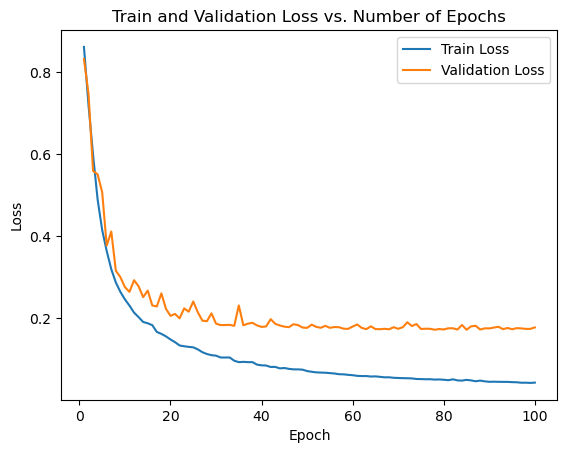

In [19]:
    # Initialize the EarlyStopping callback with patience=5 and mode='min'
#     early_stopping = EarlyStopping(patience=5, mode='min')

    # Train the model
    num_epochs = 100
    train_loss_values, val_loss_values, train_iou,val_iou,best_model_state = train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    
    # Plot the train and valdiation loss vs. the number of epochs
    plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Train Loss")
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss vs. Number of Epochs")
    plt.legend()
    plt.show()
    
    # Save the best model's state to a file
    if best_model_state is not None:
        save_best_model(best_model_state, "history_AdaGrad_0.001__100epochs_GELU_tag31.pth")

In [20]:
import pickle

# Assuming train_loss_values and val_loss_values are already defined

# Saving data into a dictionary
data = {
    'train_loss_values': train_loss_values,
    'val_loss_values': val_loss_values,
    'train_iou_values': train_iou,
    'val_iou_values': val_iou,
    'train_dicecoeff_values': 1 - np.array(train_loss_values),
    'val_dicecoeff_values': 1 - np.array(val_loss_values)
}

# Specify the file path where you want to save the data
file_path = 'history_Adagrad_0.001_GELU_100epochs_tag31.pkl'

# Open the file in binary write mode and dump the data using pickle
with open(file_path, 'wb') as file:
    pickle.dump(data, file)